# Анализ бизнес-показателей приложения.

Проведен анализ данных от ProcrastinatePRO+.
Рассчитаны различные метрики, использован когортный анализ: LTV, CAC, Retention rate, DAU, WAU, MAU и т.д. Использованы уже написанные ранее функции расчёта метрик. Сделаны правильные выводы по полученным данным.
Таким образом, исследование пройдёт в пять этапов:

 1. Предобработка и обзор данных.
 2. Создание функции для расчета и анализа LTV, ROI, удержания и конверсии.
 3. Исследовательский анализ данных.
 4. Маркетинговый анализ данных.
 5. Оценка окупаемости рекламы для привлечения пользователей

## Предобработка данных

Импортируем следующие библиотеки для проведения анализа.

In [76]:
import pandas as pd
from datetime import datetime, timedelta
import math 
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from math import ceil

Загрузим данные о визитах в переменную `visits` и проведем преобразования.

In [77]:
visits = pd.read_csv('/datasets/visits_info_short.csv')

#преобразование наименований
visits = visits.rename(columns={'User Id': 'user_id', 'Session Start': 'session_start', 'Session End': 'session_end'})
visits.columns = visits.columns.str.lower()

# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start']) 
visits['session_end'] = pd.to_datetime(visits['session_end']) 

#проверим датасет на наличие дубликатов
print('Количество явных дубликатов в датасете visits:' ,visits.duplicated().sum())

Количество явных дубликатов в датасете visits: 0


Во избежание ошибок, посмотрим на уникальные значения категориальных данных:

In [78]:
datasets = ['region', 'device', 'channel']

for name in datasets:
    print('Уникальные значения в столбце',name ,visits[name].unique())
    print()

Уникальные значения в столбце region ['United States' 'UK' 'France' 'Germany']

Уникальные значения в столбце device ['iPhone' 'Mac' 'Android' 'PC']

Уникальные значения в столбце channel ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']



Таким образом мы видим, что пользователи приложения находятся в США, Германии, Великобритании и Франции. Устройства, которыми пользуются пользователи - iPhone, Mac, Android, и персональный компьютер РС.

Загрузим данные о заказах в переменную `orders` и проведем преобразования.

In [79]:
orders = pd.read_csv('/datasets/orders_info_short.csv')

#преобразование наименований
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})

# преобразуем данные о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt']).dt.date #усечем время сессии до даты
orders['event_dt'] = pd.to_datetime(orders['event_dt']) #преобразуем тип данных

#проверим датасет на наличие дубликатов
print('Количество явных дубликатов в датасете orders:' ,orders.duplicated().sum())

Количество явных дубликатов в датасете orders: 2


Загрузим данные о расходах в переменную `costs` и проведем преобразования.

In [80]:
costs = pd.read_csv('/datasets/costs_info_short.csv')

costs.columns = costs.columns.str.lower() #приведем наименования к нижнему регистру 
costs['dt'] = pd.to_datetime(costs['dt']) #преобразуем тип данных

#проверим датасет на наличие дубликатов
print('Количество явных дубликатов в датасете costs:' ,costs.duplicated().sum())

Количество явных дубликатов в датасете costs: 0


## Функции для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии.

### Функция для создания пользовательских профилей

In [81]:
def get_profiles_nocost(sessions, orders):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверьте, есть ли ID пользователей из profiles в orders
    profiles['payer'] =  profiles['user_id'].isin(orders['user_id'].unique())

    return profiles

#функция для создания профилей с использованием сас

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    costs['dt']=costs['dt'].dt.date
    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


### Функция для расчёта удержания

In [82]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта конверсии

In [83]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта LTV и ROI

In [84]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания фрейма

In [85]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания

In [86]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [87]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [88]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Применим фугнкцию `get_profiles_nocost` к датасетам visits и orders.

In [89]:
# строим профили по двум наборам данных
profiles_nocost = get_profiles_nocost(visits, orders)
profiles_nocost.head()

,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False


Далее, определим минимальную и максимальную дату привлечения пользователей:

In [90]:
print('Первая дата привлечения пользователя:' ,profiles_nocost['dt'].min())
print('Последняя дата привлечения пользователя:' ,profiles_nocost['dt'].max())

Первая дата привлечения пользователя: 2019-05-01
Последняя дата привлечения пользователя: 2019-10-27


Итак, минимальная и максимальная даты привлечения пользователей - 1 мая и 27 октября 2019 года.
Выясним из каких стран приходят посетители и какие страны дают больше всего платящих пользователей.

In [91]:
pivot_region = (
    profiles_nocost.groupby('region')
    .agg({'user_id': 'nunique','payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.background_gradient('BuGn').format({'payer':'{:.2%}'})  
)

pivot_region

,user_id,payer
region,,
United States,100002,6.90%
Germany,14981,4.11%
UK,17575,3.98%
France,17450,3.80%


Таким образом мы выяснили, что наибольшее количество пользователей приходится на США (более 100 тыс. чел.), также как и количество платящих пользователей - 6,9%.
Далее, определим, какими устройствами пользуются пользователи приложения и с каких устройств чаще всего заходят платящие пользователи.

In [92]:
pivot_device = (
    profiles_nocost.groupby('device')
    .agg({'user_id': 'nunique','payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.background_gradient('BuGn').format({'payer':'{:.2%}'})    
)
pivot_device

,user_id,payer
device,,
Mac,30042,6.36%
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%


Итак, мы видим что основные устройства для входа в приложение - устройства Iphone, однако покупки совершаются чаще всего с устройств Mac.
В заключении, определим по каким рекламным каналам шло привлечение пользователей и какие каналы приносят больше всего платящих пользователей.

In [93]:
pivot_channel = (
    profiles_nocost.groupby('channel')
    .agg({'user_id': 'nunique','payer': 'mean'})
    .sort_values(by='payer', ascending=False)
)
pivot_channel = pivot_channel.sort_values(by = 'payer', ascending = False)
pivot_channel.style.background_gradient('coolwarm').format({'payer':'{:.2%}'})

,user_id,payer
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


Таким образом, мы определили, что в основном пользователи самостоятельно скачивают приложение, однако платящие пользователи приходят именно благодаря рекламе 'FaceBoom'.

## Маркетинг

Используем функцию `get_profiles` для получения профилей пользователей со стоимостью привлечения каждого посетителя сайта. 

In [94]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Теперь можно посчитать общую сумму расходов на маркетинг.

In [95]:
# считаем общую cумму затрат на привлечение пользователей
print('Общая cумма затрат на привлечение пользователей составляет',round(profiles['acquisition_cost'].sum()))

Общая cумма затрат на привлечение пользователей составляет 105497


Мы выяснили что с 1 мая по 27 октября 2019 года компания потратила 105 тыс. долларов на маркетинг для привлечения пользователей, но во сколько в среднем компания затратила на одного пользователя?

In [96]:
profiles_no_organic = profiles.query('channel != "organic"') # очистим фрейм от органический пользователей

print('Привлечение каждого пользователя в среднем составляет',round(profiles_no_organic['acquisition_cost'].mean(),2))

Привлечение каждого пользователя в среднем составляет 1.13


Итак, компания потратила на каждого пользователя в среднем 1,13 доллара. Проанализируем сумму расходов по каждому источнику привлечения и определим среднюю стоимость каждого пользователя. Для этого построим сводную таблицу по профилям

In [97]:
# считаем средний CAC по каналам привлечения

cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': ['sum', 'mean']})

)

cac.columns = ['cac_total', 'cac_mean']
cac.sort_values(by = 'cac_total', ascending = False)
cac.style.background_gradient('coolwarm').format({'cac_mean':'{:.2f}', 'cac_total':'{:.2f}'})

,cac_total,cac_mean
channel,,
AdNonSense,3911.25,1.01
FaceBoom,32445.60,1.11
LeapBob,1797.60,0.21
MediaTornado,954.48,0.22
OppleCreativeMedia,2151.25,0.25
RocketSuperAds,1833.00,0.41
TipTop,54751.30,2.80
WahooNetBanner,5151.00,0.60
YRabbit,944.22,0.22


Около половины расходов на рекламу приходится на источник Tiptop и около трети на FaceBoom, мы помним что именно эти два источника приносят больше всего платящих пользователей. Однако, мы видим, что средняя стоимость привлеченного пользователя Tiptop явно превышает средний показатель (2,8 доллара против 1,13).\
Посмотрим, как изменялся САС по времени.

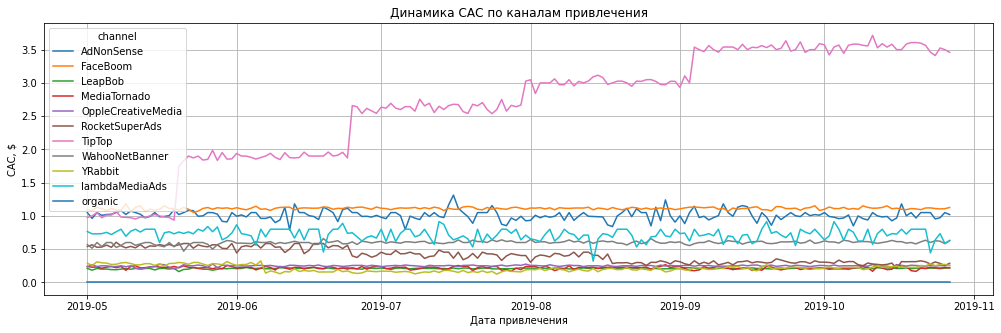

In [98]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(17, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Итак, мы видим, что за 6 месяцев рекламной компании все источники кроме TipTop оставались на стабильном уровне. На привлечение пользователей в TipTop практически каждый месяц компания увеличивала расходы. Однако, из исследовательского анализа мы помним что большего всего платящих пользователей приносил источник FaceBoom при одинаковых суммах расходов. Тем не менее выводы делать рано - необходимо проанализировать окупаемость реклам в разных разрезах и временных метриках.  

## Анализ окупаемости рекламы для привлечения пользователей

Для анализа окупаемости рекламы нам необходимо посчитать сумму денег, которую один клиент в среднем приносит компании со всех своих покупок (LTV). Далее, определим на сколько процентов LTV превысил CAC, то есть ROI, или Return On Investment, — окупаемость инвестиций. Перед анализом нам лучше исключить органических пользователей из profiles, т.к. мы за них не платим.

In [99]:
profiles_no_organic = profiles.query('channel != "organic"') 

### Анализ общей окупаемости рекламы

 Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

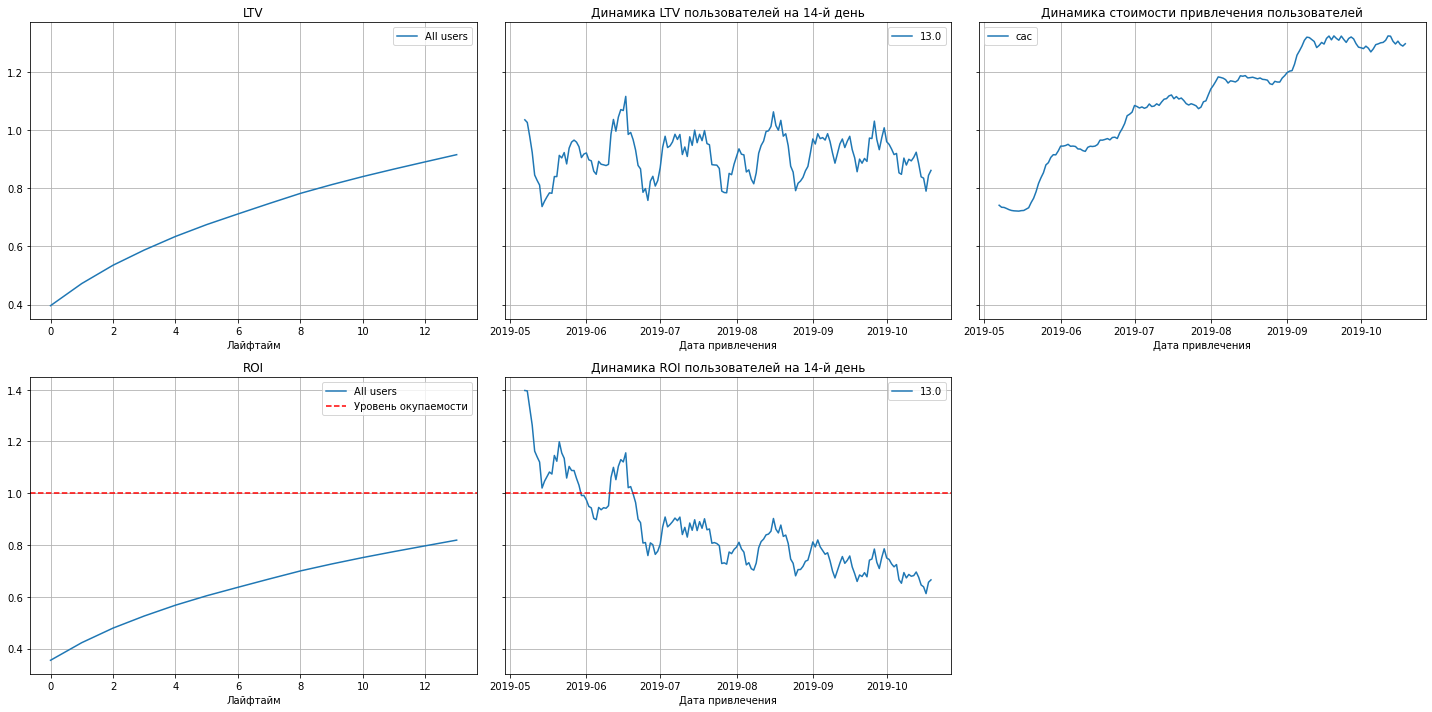

In [100]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:\
На LTV влияет сезонный фактор, но показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
Реклама не окупается. ROI окупался в мае-июне, однако после июля, рекламная кампания стала убыточной. Все потому что CAC растет. Ранее мы выяснили что было увеличение рекламного бюджета на источник Tiptop.
Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Анализ окупаемости рекламы с разбивкой по устройствам

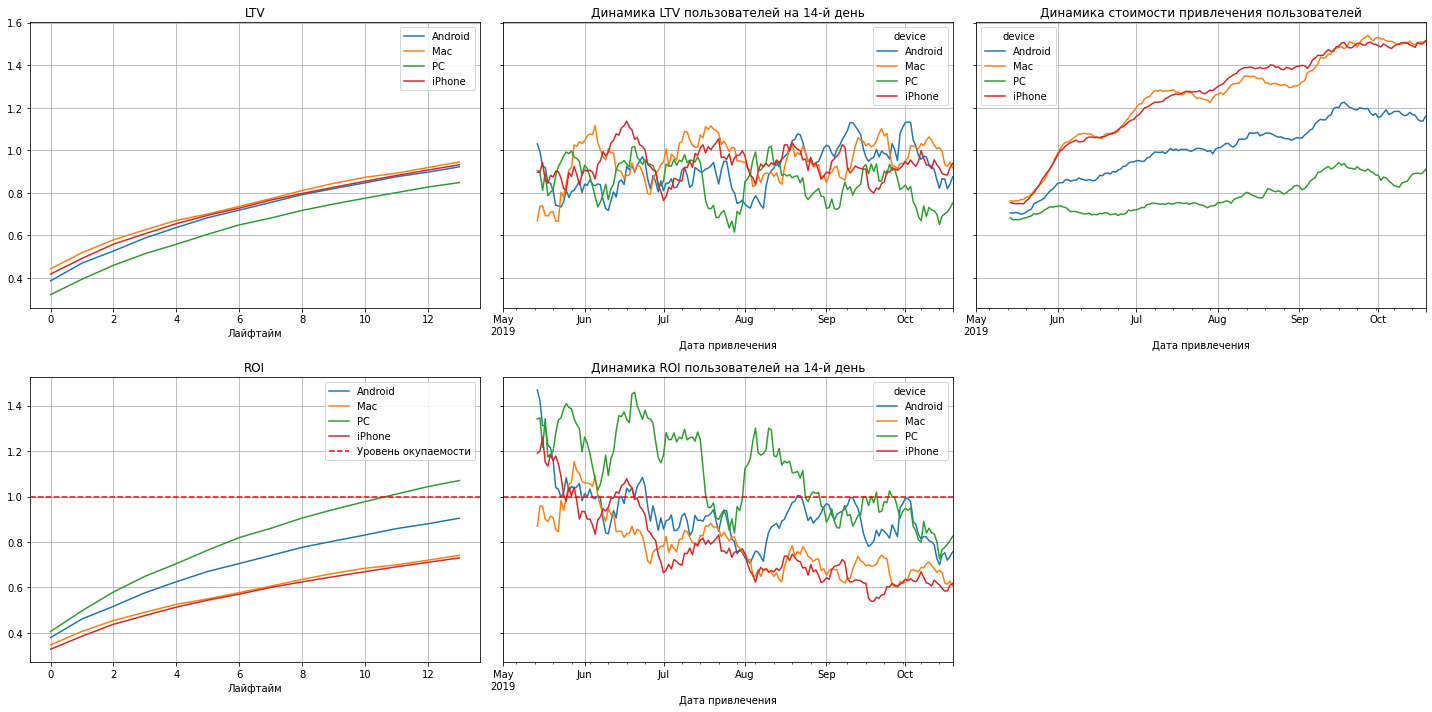

In [101]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

С разбивкой по девайсам мы обнаружили что:\
- Реклама окупается только на устройствах РС, что значит проблема именно в мобильных приложениях.\
- Стоимость привлечения выросла в прямопропорциональном значении для каждого устройства.\

Перейдем к анализу регионов.

### Анализ окупаемости рекламы с разбивкой по странам

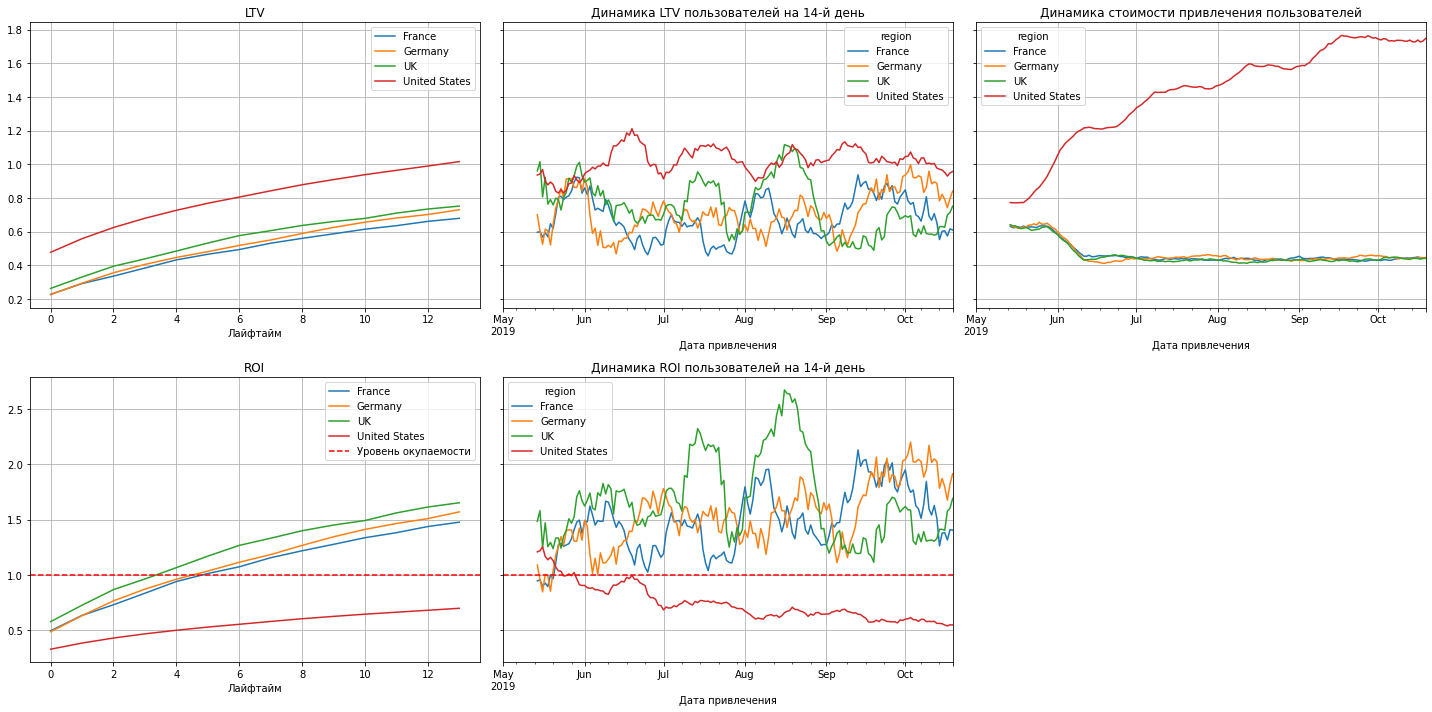

In [102]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

С разбивкой по странам мы видим, что не во всех регионах всё стабильно плохо.\

Вот что говорят графики:\
- Реклама не окупается только в США. Стоимость привлечения стабильна и одинакова для всех стран, кроме США - именно там было произошло увеличение рекламного бюджета.\
- LTV всё так же подвержен сезонности, но стабилен.\
- Хуже всего окупается США, а вот явных лидеров нет. Значит, основные убытки компании приходятся на США.\

Теперь проверим источники привлечения (channel). Необходимо найти в каком именно канале на окупаемость влияет неудачная реклама.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

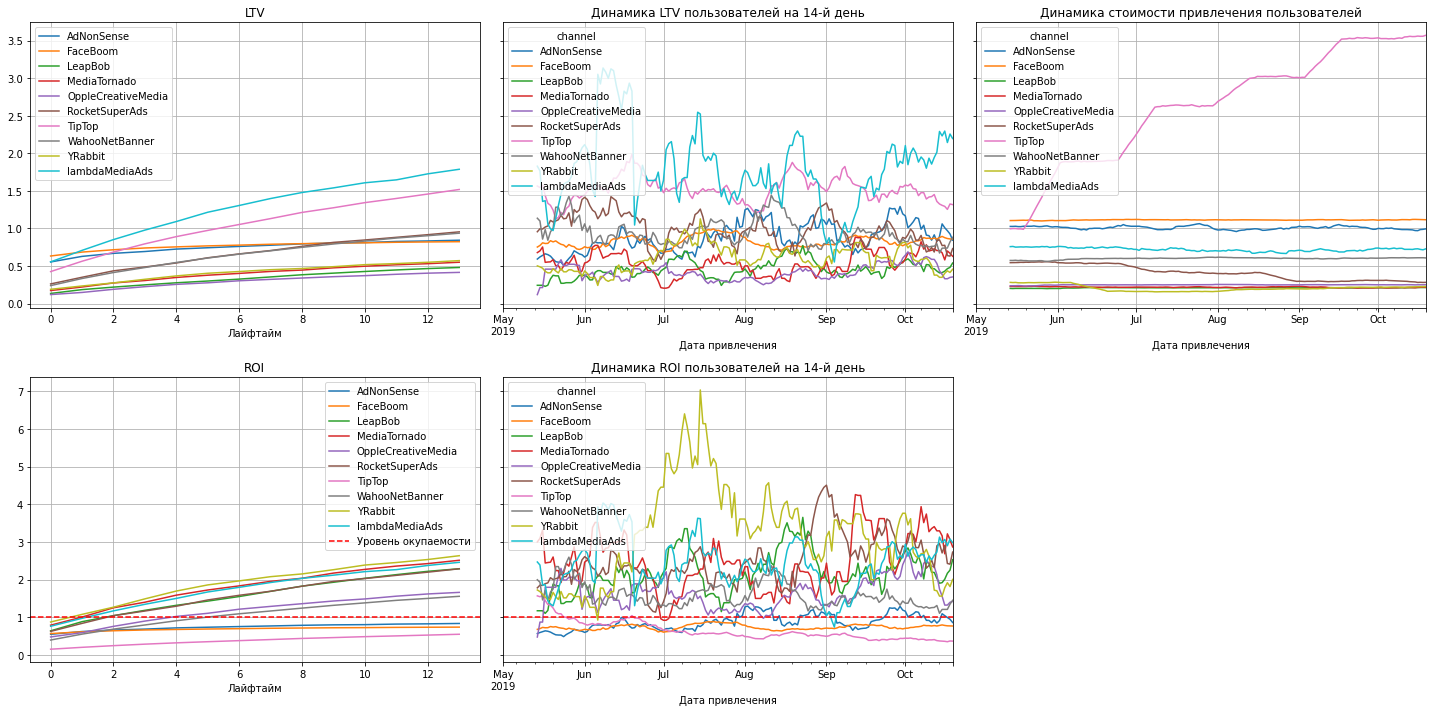

In [103]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Мы обнаружили, что самый рентабельный источник Yrabbit. В целом, все источники окупаются кроме TipTop и FaceBoom. Причем на FaceBoom не было увеличение рекламного бюджета, значит дело в другом.

Узнаем, в чём причина: в низкой конверсии или низком удержании.

### Анализ конверсии пользователей

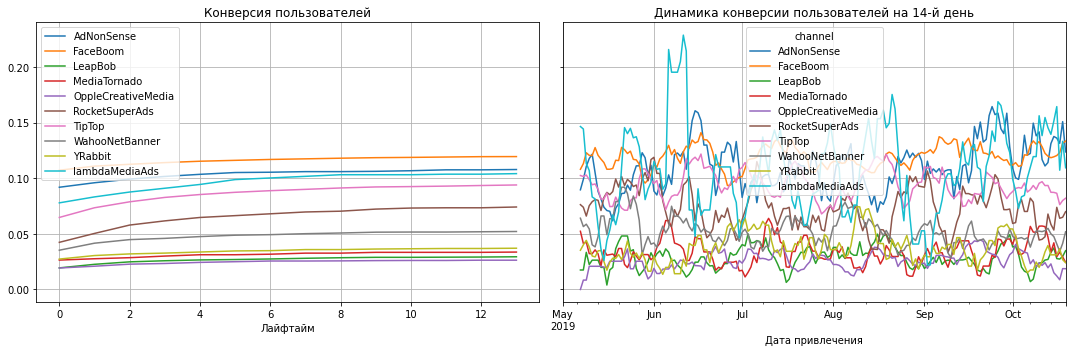

In [104]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по полученному графику, конверсия в TipTop находилась на стабильно одинаковом уровне, несмотря на постояные увеличения рекламного бюджета. В то же время, самая высокая конверсия у источника FaceBoom.

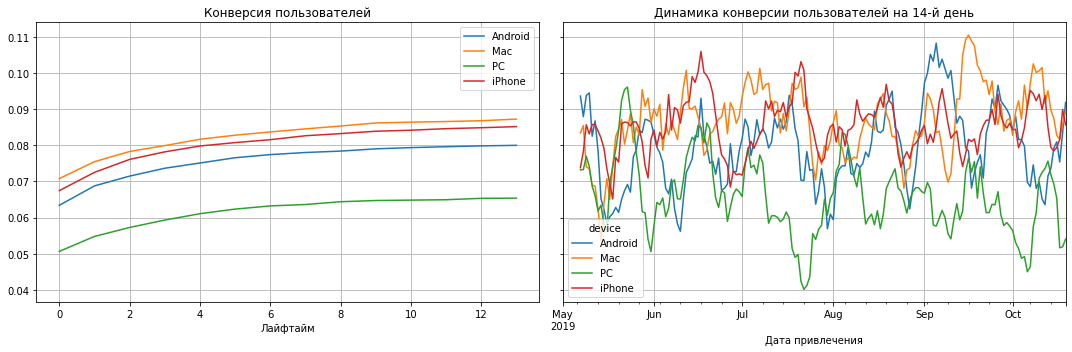

In [105]:
# смотрим конверсию с разбивкой по девайсам


conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Здесь мы видим, что пользователи Apple охотнее становятся покупателями. Посмотрим на конверсию в регионах.

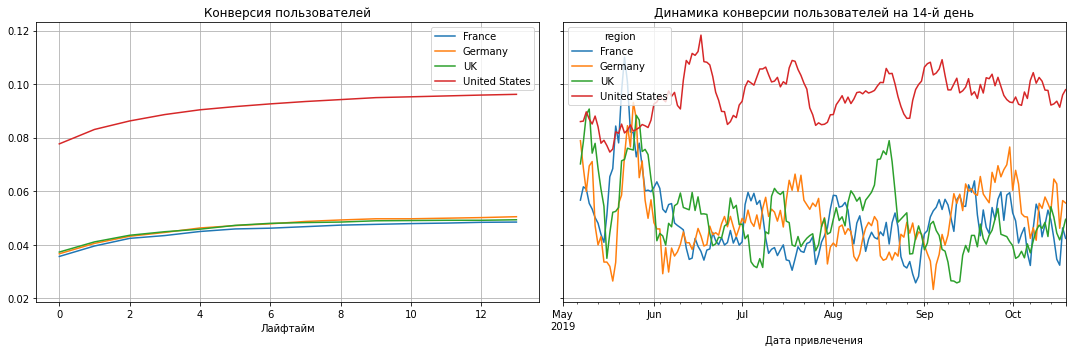

In [106]:
# смотрим конверсию с разбивкой по регионам


conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи в США на убыточных каналах конвертируются очень хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

### Анализ удержания пользователей

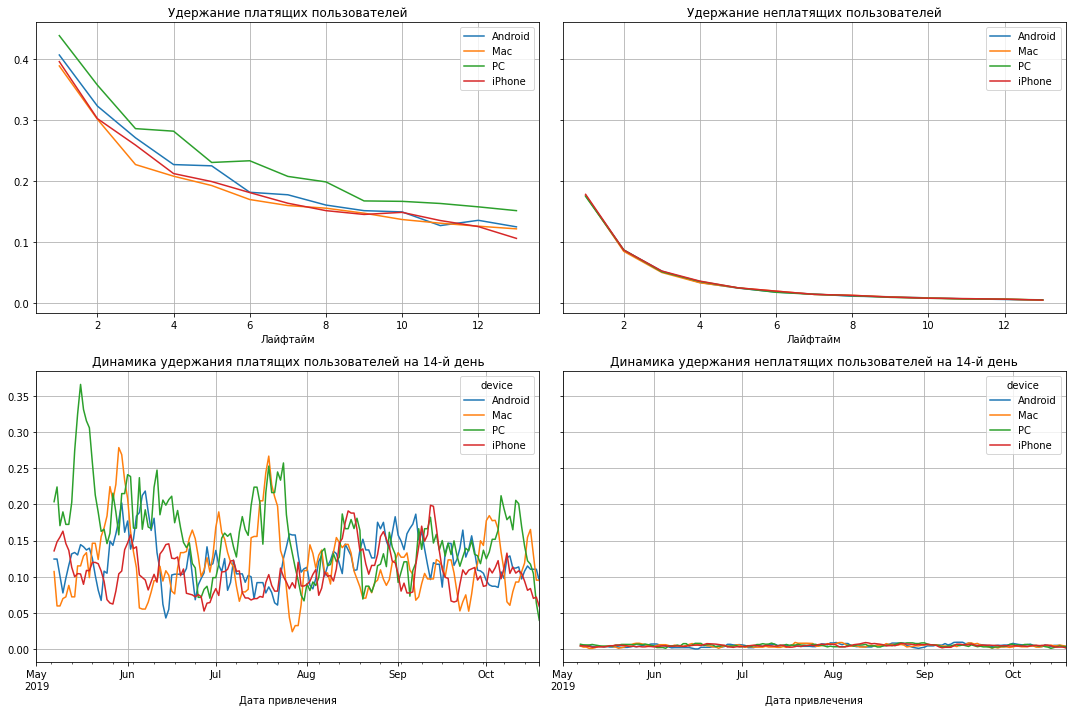

In [107]:
# смотрим удержание с разбивкой по девайсам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Судя по анализу удержания с разбивкой по девайсам все стабильно плохо. Но явных аутсайдеров нет, значит дело не в устройствах.
Посмотрим на удержание по странам.

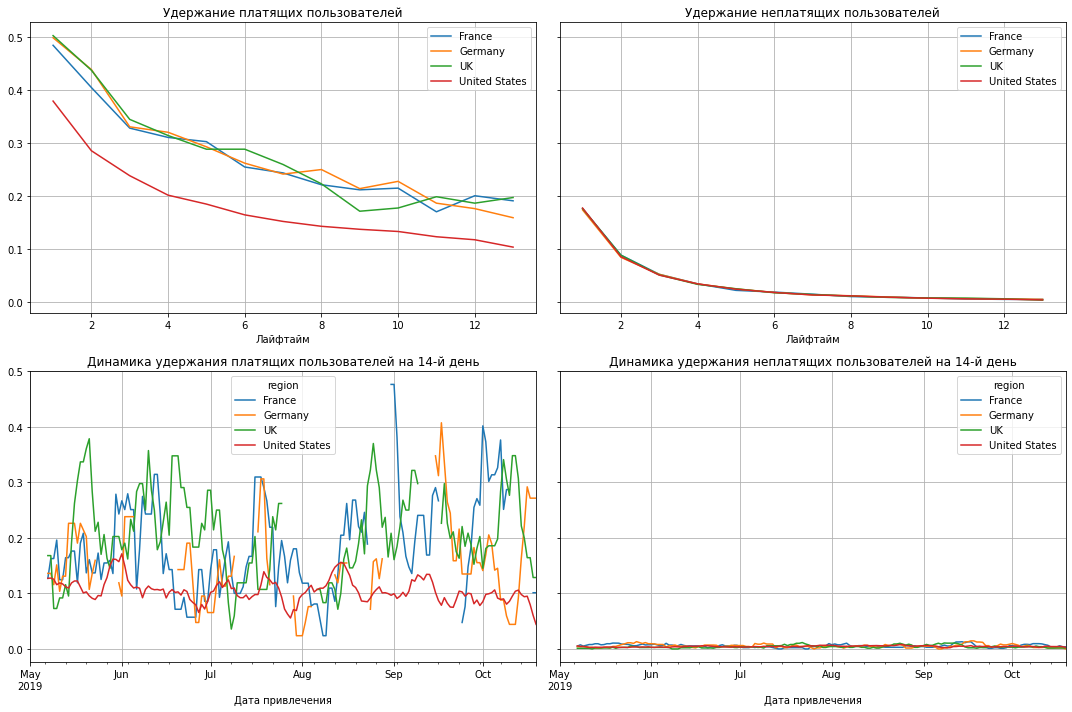

In [108]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Итак, мы плавно приближаемся к первопричине низкой окупаемости рекламы. По графику четко видно, что удержание платящих пользователей в США явно ниже, чем в остальных странах. Посмотрим, каеи именно источники оказывают наибольшее влияние на этот негативный тренд. 

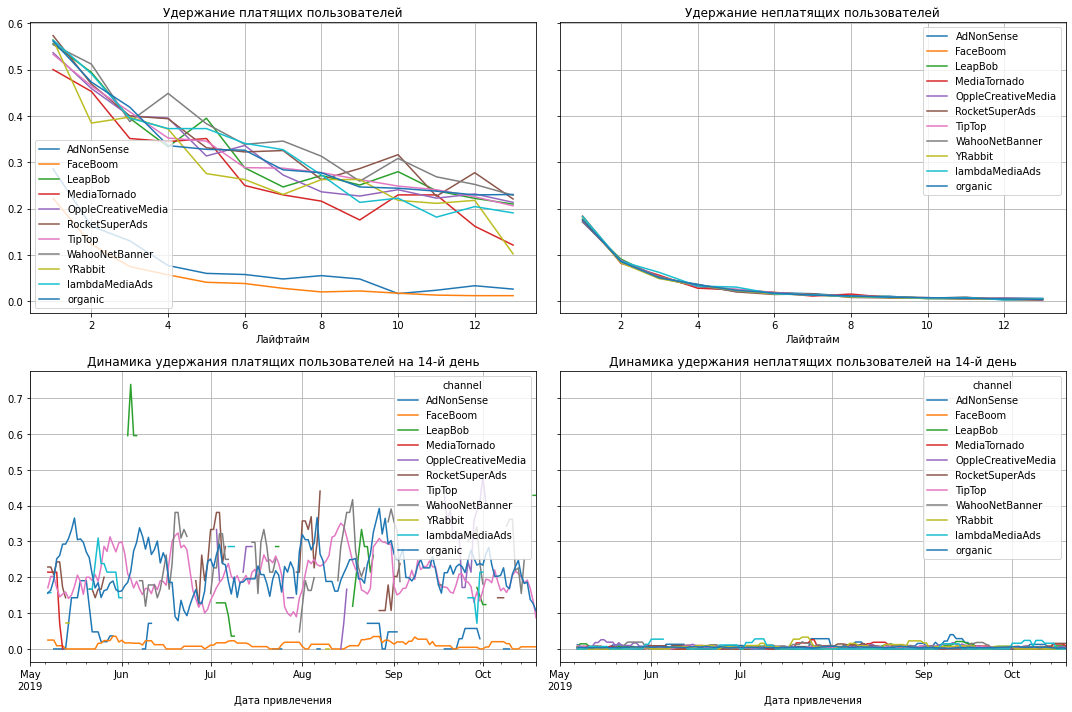

In [109]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Действительно, пользователи источников FaceBoom и AdNonSense стабильно плохо удерживаются. Для платящих пользователей этих источников удержание менее 10% уже на 4ый день что на 20% ниже, чем на остальных устройствах. Это очень низкий показатель.\
В то же время, мы видим, что несмотря на то, что расходы на TipTop увеличивались от месяца к месяцу более чем на 50%, это не повлияло на удержание пользователей.
Интересно, что за весь изучаемый период, высокая конверсия была только в источнике LeapBob на 14ый день. Быть может это и есть перспективный источник для роста?
Посмотрим еще раз на удержание пользователей с разбивкой по каналам именно в США.


Создадим датафрейм, который показывает статистику только по США.

In [110]:
profiles_usa = profiles.query('region=="United States"')

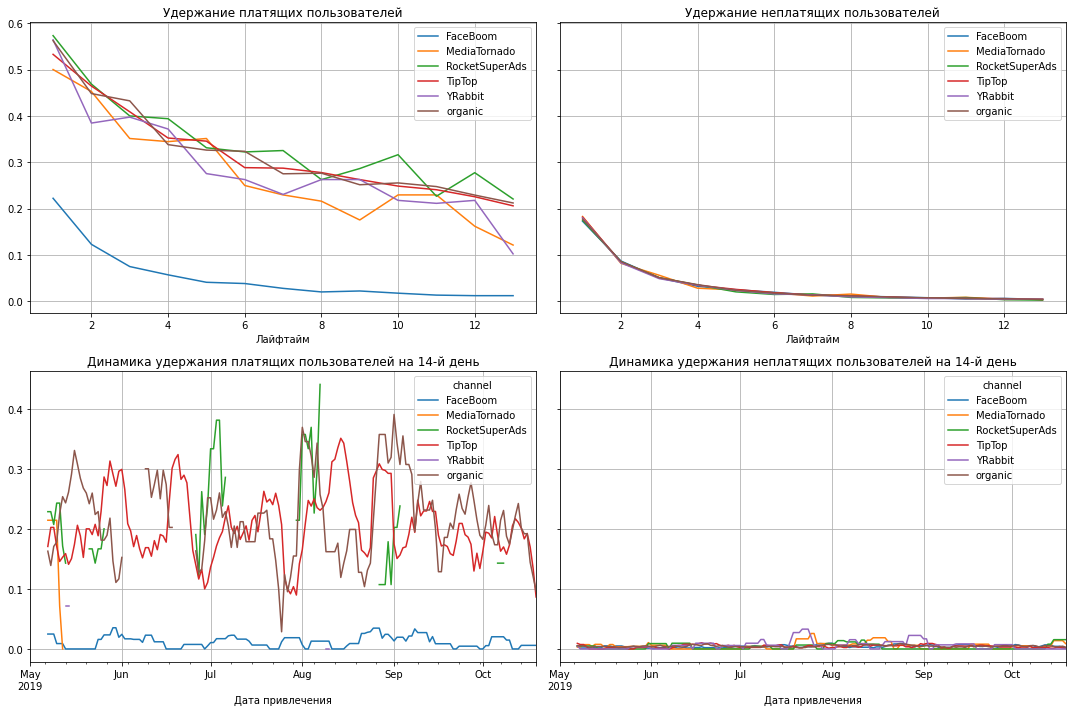

In [111]:
# смотрим удержание с разбивкой по каналам в США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Итак, мы обнаружили, что в целом лидером по удержанию можн назвать RocketSuperAds, но является ли он рентабельным? Посмотрим на окупаемость.

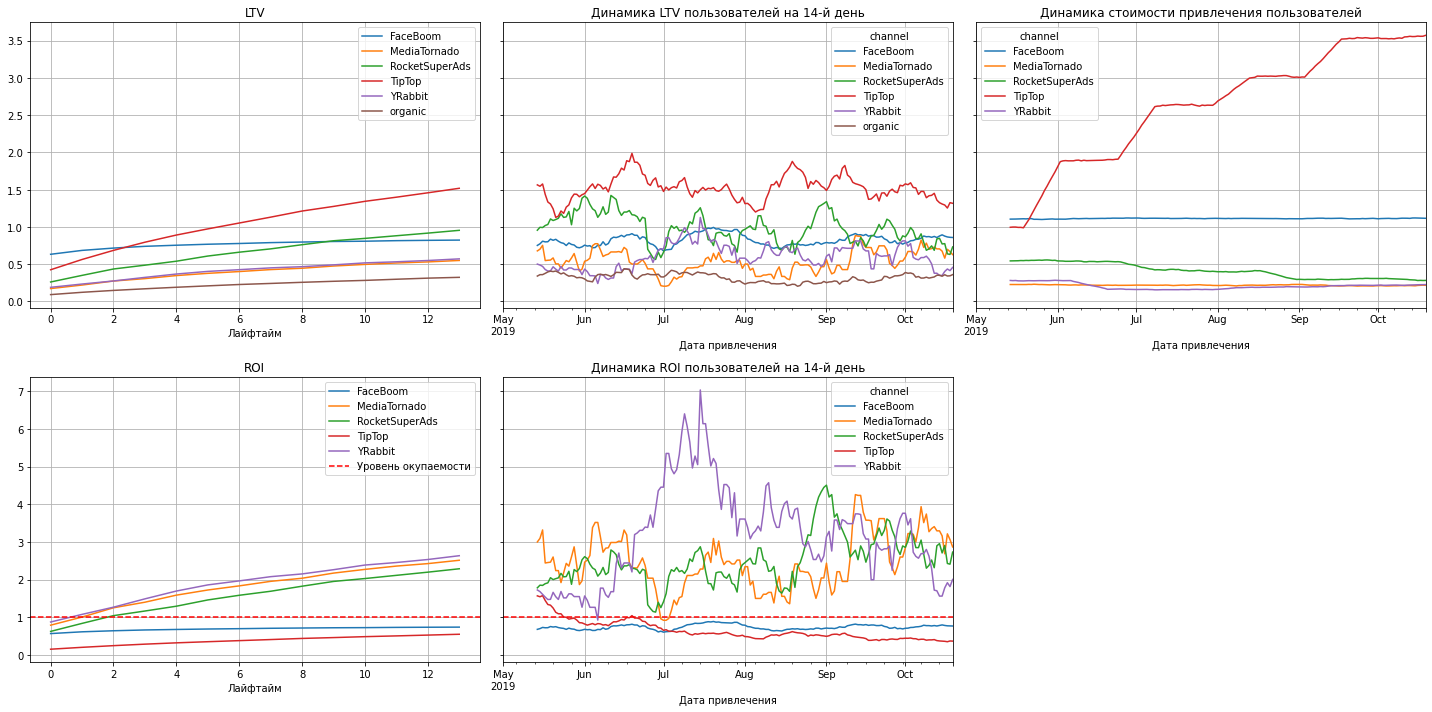

In [112]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Таким образом мы обнаружили два источника для развития рекламной кампании:\
1. RocketSuperAds - поскольку является лидером в удержании и окупается уже на второй день лайфтайма.
2. YRabbit - поскольку является лидером в окупаемости, но необходимо улучшить динамику удержания платящих пользователей.\

Возможно именно сюда стоит перенаправить расходы бюджета рекламной кампании с источника TipTop.  

## Вывод

Таким образом, выполнив исследовательский и маркетинговый анализ окупаемости рекламы для привлечения пользователей, мы можем сделать следующие выводы:

1. В целом, основная часть платящих пользователей приходится на США, как и основная часть расходов на рекламу.
2. Большая часть затрат приходится на источник TipTop и FaceBoom как и большая часть покупателей.
3. За анализируемый период наблюдались увеличения рекламного бюджета в TipTop.
4. При анализе окупаемости мы обнаружили, что рекламная кампания за указаный срок была убыточной именно из-за увеличения рекламного бюджета, не смотря на высокую конверсию пользователей по указанным источникам. Однако, после анализа удержания мы выяснили что несмотря на высокую конверсию и стабильном САС, пользователи источника FaceBoom удерживаются на уровне 10%, что является очень низким показателем. В то же время, удержание пользователей TipTop находится на уровне 20% на 14ый день, что явно не оправдывает вложенных средств.

Таким образом, мы определили, что рекламная кампания при увеличении бюджета в TipTop оказалась неэффективной ни для конверсии пользователей, ни для их удержания. Однако, мы выявили три перспективных источника для увеличения прибыли компании:\
1. Для того чтобы увеличить удержание платящих пользователей, компании необходимо акцентировать свое внимание и вывить причину низкого удержания в источнике FaceBoom. Скорее всего политика данного источника заключается в подарке за первую покупку, после чего у пользователей пропадает стимул для дальнейших покупок.  
2. Для того чтобы поднять конверсию, рекомендуется обратить внимание и увеличить рекламный бюджет в источники RocketSuperAds и YRabbit, поскольку данные источники показывают хорошие показатели удержания и окупаемости. Здесь необходимо сделать акцент на увеличении конверсиии пользователей. 